# Data analysis project : Energy

Written by Julien Samuel, Mayuxiang Chen and Jolan Kerrien

In [96]:
import numpy as np
from scipy import stats
import pandas as pd

#Ploting librairies:
import matplotlib.pyplot as plt
import seaborn as sns

#linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error #r2_score

## 1) Graphical Representation of all the variables with respect to the target + Computing the correlation

In [2]:
# Importation of the data 
df = pd.read_csv('energy_data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,North,0.0,type1,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,South,0.0,type1,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,Est,0.0,type1,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,West,0.0,type1,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,North,0.0,type1,20.84,28.28


Correspondance of the variable
- X1 Relative Compactness
- X2 Surface Area
- X3 Wall Area
- X4 Roof Area
- X5 Overall Height
- X6 Orientation
- X7 Glazing Area
- X8 Glazing Area Distribution

Functions that will help us through our analysis

In [100]:
def identify_missing(data): 
    ''' Identify the features missing values NaN
    Return list of features with the number of missing values 
    input = dataframe and print dataframe '''
    missing = data.isnull().sum()
    missing_result = pd.DataFrame(missing).reset_index().rename(columns = {'index' : 'features', 0 :'missing_nbr'})
    missing_result['missing_fraction']=(missing_result.missing_nbr/data.shape[0])*100
    print(missing_result)
    
def information_about_data(data): 
    '''numeric features : get the min and the max
       categorical features get the nbr of classes
       input = a dataframe and prints statistics of columns of this dataframe'''
    print(" ")
    print("Numerical features")
    for col in data.columns : 
        if data[col].dtype != 'object' :
            print('The feature "%s" have a minimum value of %s and a maximum value of %s' % (col,data[col].min(), data[col].max()))

    print(" ")
    print("Categorical features")
    for col in data.columns : 
        if data[col].dtype == 'object' :
            print('The feature "%s" have %s unique values which are %s' % (col,len(data[col].unique()),data[col].unique()))
            
def Plot(df,Y_value):
    for i in [1,2,3,4,5,7]:
        plt.plot(df[f'X{i}'],df[f'Y{Y_value}'],'.',label = f'Y{Y_value} (X{i})')
        plt.legend()
        plt.show()
    

In [101]:
identify_missing(df)

  features  missing_nbr  missing_fraction
0       X1            0               0.0
1       X2            0               0.0
2       X3            0               0.0
3       X4            0               0.0
4       X5            0               0.0
5       X6            0               0.0
6       X7            0               0.0
7       X8            0               0.0
8       Y1            0               0.0
9       Y2            0               0.0


There is no missing numbers in our data, so no need to think about a way to replace them

In [102]:
information_about_data(df)

 
Numerical features
The feature "X1" have a minimum value of 0.62 and a maximum value of 0.98
The feature "X2" have a minimum value of 514.5 and a maximum value of 808.5
The feature "X3" have a minimum value of 245.0 and a maximum value of 416.5
The feature "X4" have a minimum value of 110.25 and a maximum value of 220.5
The feature "X5" have a minimum value of 3.5 and a maximum value of 7.0
The feature "X7" have a minimum value of 0.0 and a maximum value of 0.4
The feature "Y1" have a minimum value of 6.01 and a maximum value of 43.1
The feature "Y2" have a minimum value of 10.9 and a maximum value of 48.03
 
Categorical features
The feature "X6" have 4 unique values which are ['North' 'South' 'Est' 'West']
The feature "X8" have 6 unique values which are ['type1' 'type2' 'type3' 'type4' 'type5' 'type6']


### Tracer des $X_i$ en fonction de $Y_1$ puis $Y_2$

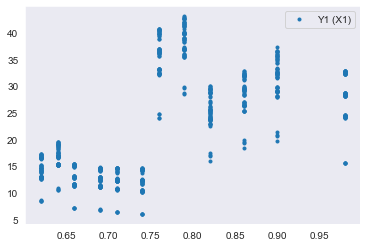

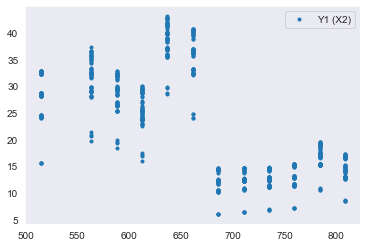

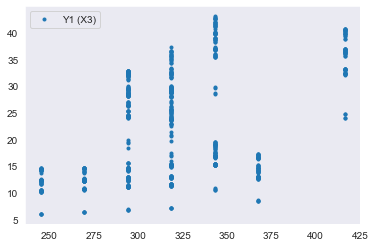

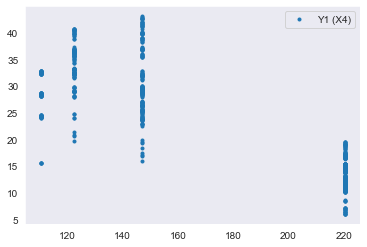

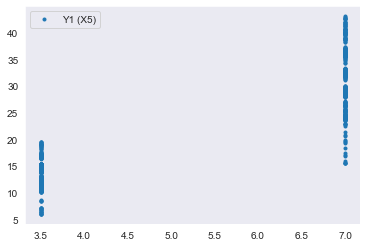

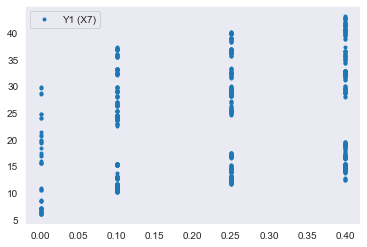

In [103]:
Plot(df,1)

## 2) Transformation of the categorical variables

Julien

In [104]:
def plot_figure(axx,w,h,df):
    ''' input = dataframe df , name of column of interest axx , width and height of the graph
        we will rotate the ticks of the x axis and ha=right means that 
        If we imagine a rectangular box around the rotated label, 
        which side of the rectangle do we want to be aligned with the tickpoint '''
    plt.figure(figsize=(w,h))
    sns.countplot(df[axx])
    plt.xticks(rotation = 30, ha='right')
    plt.title(axx + ' distribution')
    plt.show()

#plot distribution between a categorical value and a numerical value in an histogram via predefined function
def plot_figure_num(x_var,groupby_var,w,h, nbr_bins,x_min, x_max,step_x,df,colors):
    '''input : name of numerical variable , name of categorical variable ,width,height, 
               nbr_bins,x_min numeric, x_max numeric,step_x to show ,dataframe'''
    #x_var = 'hours-per-week'
    #groupby_var = 'income'
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]
    plt.figure(figsize=(w,h))
    n, bins, patches = plt.hist(vals, nbr_bins, stacked=True, color=colors[:len(vals)], edgecolor = 'black') 
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.xlabel(x_var)
    plt.ylabel("count")
    plt.xticks(np.arange(x_min, x_max, step=step_x))
    plt.title(x_var + ' distribution in function of ' + groupby_var)
    plt.show()

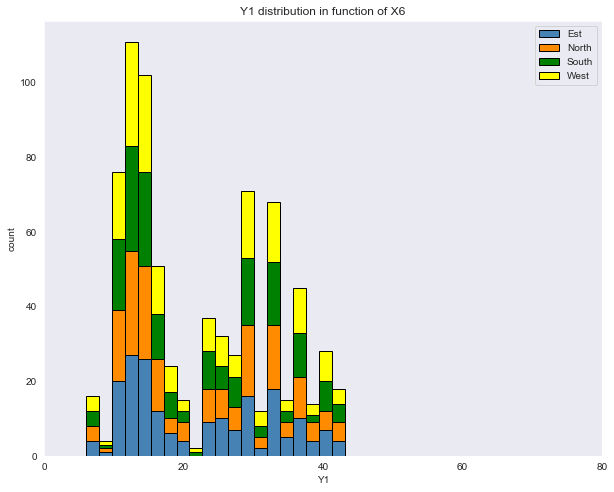

In [105]:
plot_figure_num('Y1','X6',10,8, 20,0, 100,20,df,['steelblue','darkorange','green','yellow'])

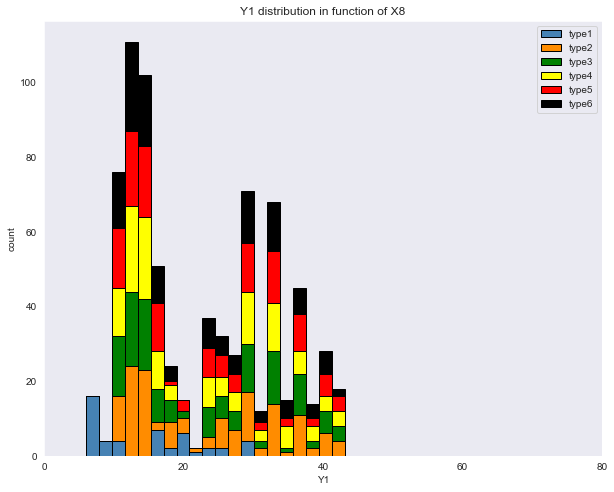

In [106]:
plot_figure_num('Y1','X8',10,8, 20,0, 100,20,df,['steelblue','darkorange','green','yellow','red','black'])

### Transformation of the variable

The orientation X6 can be replace by:
North : 1  
South : 2  
West : 3
Est : 4
The glazing area distribution X8 can be replace by 1,2,3,4,5,6  
type 1 : 1  
type 2 : 2  
..

In [3]:
def transfX6(df):
    df_new = df.copy()
    list = {"X6" : {"North":1, "South":2, "West":3, "Est":4}}
    df_new = df_new.replace(list)
    return df_new

def transfX8(df):
    df_new = df.copy()
    list = {"X8" : {"type1":1, "type2":2, "type3":3, "type4":4, "type5":5, "type6":6}}
    df_new = df_new.replace(list)
    return df_new

In [4]:
X6_num = transfX6(df)
X8_num = transfX8(df)

df1 = pd.DataFrame(X6_num)
df2 = pd.DataFrame(X8_num)
df1['X8']=df2['X8']

df_num = df1.copy()
df_num.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,1,0.0,1,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,2,0.0,1,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,1,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,3,0.0,1,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,1,0.0,1,20.84,28.28


In [5]:
## Stats with the numerical values
stat = pd.DataFrame()
stat['mean'] = df_num.mean()
stat['Var'] = df_num.var()
stat['Std.Var'] = df_num.std()
stat

,mean,Var,Std.Var
X1,0.764167,0.011189,0.105777
X2,671.708333,7759.163842,88.086116
X3,318.500000,1903.269883,43.626481
X4,176.604167,2039.963060,45.165950
X5,5.250000,3.066493,1.751140
X6,2.500000,1.251630,1.118763
X7,0.234375,0.017748,0.133221
X8,3.812500,2.405476,1.550960
Y1,22.307201,101.812050,10.090196
Y2,24.587760,90.502983,9.513306


## 3) Normalize variables

In [268]:
#df_norm = (df_norm - df_norm.min())/(df_norm.max()-df_norm.min())
df_norm = (df_num-df_num.mean())/df_num.std()

df_norm.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,2.040447,-1.784712,-0.561586,-1.469119,0.999349,-1.340767,-1.7593,-1.813393,-0.669680,-0.342443
1,2.040447,-1.784712,-0.561586,-1.469119,0.999349,-0.446922,-1.7593,-1.813393,-0.669680,-0.342443
2,2.040447,-1.784712,-0.561586,-1.469119,0.999349,1.340767,-1.7593,-1.813393,-0.669680,-0.342443
3,2.040447,-1.784712,-0.561586,-1.469119,0.999349,0.446922,-1.7593,-1.813393,-0.669680,-0.342443
4,1.284142,-1.228438,0.000000,-1.197897,0.999349,-1.340767,-1.7593,-1.813393,-0.145409,0.388113


## 4) Shuffle dataset + split train/test subsets

Max

In [368]:
# diviser les variables
df_shuffled = df_norm.sample(frac=1).reset_index(drop=True)
X_shuff = df_shuffled[['X1', 'X2', 'X3', 'X4','X5','X6','X7','X8']]  #Variables explicatives quantitatives
Y_shuff = df_shuffled['Y1']

X_train, X_test, Y_train, Y_test = train_test_split(X_shuff, Y_shuff, test_size=0.2)  

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(614, 8) (154, 8) (614,) (154,)


## 5) Apply multiple linear regression with code seen in the class (vary alpha and nbr of iterations + comment)


Jolan

In this part, we will do a multilinear regression of Y1 depending on the other explicative variables X1,X2,X3,X4,X5,X6,X7,X8.  
$Y_{1_{pred}} = H \times W$  with H the featured matrix  
The regression matrix W will be determined using a gradient descent.  
The error (RSS) for different value of iterations and steps will be ploted and commented.

In [369]:
#Setting the matrixes

ones, ones2 = np.ones([X_train.shape[0],1]), np.ones([X_test.shape[0],1])
ones3, ones4 =  np.ones([Y_train.shape[0],1]), np.ones([Y_test.shape[0],1])
Y_train2 ,Y_test2 = np.expand_dims(Y_train, axis = 1), np.expand_dims(Y_test,axis = 1)

X_train2 , X_test2 = np.concatenate((ones,X_train),axis=1), np.concatenate((ones2,X_test),axis=1)
W = np.zeros([1,9])

In [370]:
#Functions
def computeHeatingLoad(X,Y,W):
    #return the RSS at a given matrix W
    tobesummed = np.power(((X @ W.T)-Y),2)
    return np.sum(tobesummed)/(len(X))

def gradientDescent(X,Y,W,iters,alpha):
    #return the final matrix W and the value of RSS for each iterations
    Err = np.zeros(iters)
    for i in range(iters):
        W = W - (2*alpha/len(X)) * np.sum(X * (X @ W.T - Y), axis=0)
        Err[i] = computeHeatingLoad(X, Y, W)
    return W,Err

In [371]:
#Hyper-parameters tested
Alpha = [0.0001,0.001,0.01]
Iters = [10000,1000,100]
#Init
ItersF, gitf  = [1 for x in range(len(Alpha)**2)], [1 for x in range(len(Alpha)**2)]

#Create a list in which all the errors and regression matrice at a given iteration and a given alpha are filled
for i,iters in enumerate(Iters):
    for j,alpha in enumerate(Alpha):
        gitf[i*len(Iters)+j] , ItersF[i*len(Iters)+j] = gradientDescent(X_train2,Y_train2,W,iters,alpha)

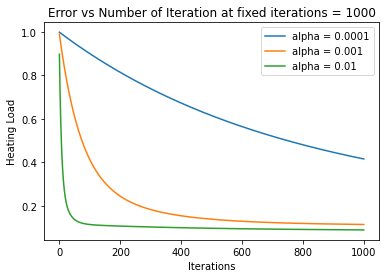

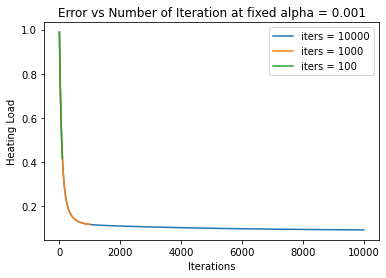

In [372]:
#Plot
for i in range(3):
    plt.plot(np.arange(Iters[1]),ItersF[i+3], label = f'alpha = {Alpha[i]}')
    plt.title('Error vs Number of Iteration at fixed iterations = 1000')
    plt.xlabel("Iterations")
    plt.ylabel("Heating Load")
    plt.legend()
plt.show()
for i in range(3):
    plt.plot(np.arange(Iters[i]),ItersF[i*3+1],  label = f'iters = {Iters[i]}')
    plt.title('Error vs Number of Iteration at fixed alpha = 0.001')
    plt.xlabel("Iterations")
    plt.ylabel("Heating Load")
    plt.legend()

In [373]:
#Final RSS Heating Load values with alpha or iters fixed
HeatingLoad = [computeHeatingLoad(X,Y,g) for g in gitf]
Results = pd.DataFrame()
Results['Value of alpha'] = Alpha
for i,iters in enumerate(Iters):
    Results[f'iters = {iters}'] = HeatingLoad[i*3:i*3+3]
Results

,Value of alpha,iters = 10000,iters = 1000,iters = 100
0,0.0001,0.114377,0.415828,0.900138
1,0.0010,0.089029,0.114366,0.415037
2,0.0100,0.083983,0.089025,0.114256


In [374]:
#Weight of the variable in the matrix W
coef_df = pd.DataFrame()
W_new = [W for W in gitf[2]][0]
coef_df['Variable'] = ['X1', 'X2', 'X3', 'X4','X5','X6','X7','X8']
coef_df['Coefficient'] = W_new[1:]
coef_df

,Variable,Coefficient
0,X1,-0.540297
1,X2,-0.267539
2,X3,0.093257
3,X4,-0.305927
4,X5,0.783724
5,X6,0.001194
6,X7,0.256035
7,X8,0.032462


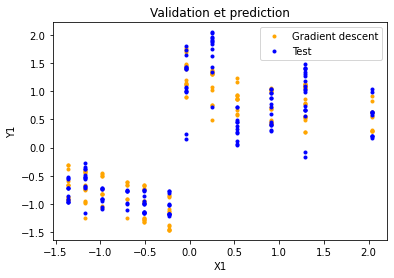

In [375]:
#Visualisation 
Y_pred = X_test2 @ W_new.T
plt.plot(X_test['X1'].to_numpy(),Y_pred,'.',linewidth=1.1,label="Gradient descent",color="orange")
plt.plot(X_test['X1'].to_numpy(),Y_test2,'.',linewidth=1.1,label="Test",color="blue")
plt.title("Validation et prediction")
plt.xlabel('X1')
plt.ylabel('Y1')
plt.legend()
plt.show()

In [376]:
#Calcul de l'erreur sur la prédiction
# Erreur quadratique moyenne (MSE)
MSE=mean_squared_error(Y_test, Y_pred)
print('Erreur quadratique moyenne (MSE):',MSE)
# Erreur quadratique moyenne carrée (RMSE)
print('Erreur quadratique moyenne carrée (RMSE):',MSE*(1/2))

Erreur quadratique moyenne (MSE): 0.08061479478788236
Erreur quadratique moyenne carrée (RMSE): 0.04030739739394118


### Comments

...  
...

## 6) Apply the linear regression of Scikit learn library (cf. the code given in class) + vary attributes and compare to question 5

We will still try to do a multilinear regression but using this time the scikit learn library (close to deep learning).  
This will allow us to find the optimal solution regarding to train and test variables.

Coefficient de détermination (R2): 0.9153218465278986
    Coefficient
X1    -0.728617
X2    -0.409870
X3     0.069253
X4    -0.433127
X5     0.700235
X6     0.001768
X7     0.255687
X8     0.032383
Erreur quadratique moyenne (MSE): 0.08122804160010678
Erreur quadratique moyenne carrée (RMSE): 0.04061402080005339


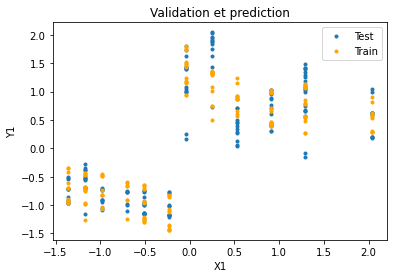

In [378]:
#Définition du modèle de régression linéaire multiple 
reg = LinearRegression().fit(X_train,Y_train)
#reg = SGDRegressor().fit(X_train, Y_train)#le modèle de descente de gradient stochastique est ajusté sur les données d'apprentissage avec fit() 
 
print('Coefficient de détermination (R2):', reg.score(X_train, Y_train))#Vérification du score de précision du modèle. 
#Coefficient de détermination (1 est une prédiction parfaite). #r2_score(Y_test, Y_pred) autre fonction.

#Coefficient de la régression 
coeff_df = pd.DataFrame(reg.coef_, X_shuff.columns, columns=['Coefficient'])
print(coeff_df) 

# Predictions utilisant les apprentissages 
Y_pred = reg.predict(X_test)

#Calcul de l'erreur sur la prédiction
# Erreur quadratique moyenne (MSE)
MSE=mean_squared_error(Y_test, Y_pred)
print('Erreur quadratique moyenne (MSE):',MSE)
# Erreur quadratique moyenne carrée (RMSE)
print('Erreur quadratique moyenne carrée (RMSE):',MSE*(1/2))  


#Visualisation 
X_ax=range(len(Y_test))
plt.plot(X_test['X1'].to_numpy(),Y_test,'.',linewidth=1,label="Test")
plt.plot(X_test['X1'].to_numpy(),Y_pred,'.',linewidth=1.1,label="Train",color="orange")
plt.title("Validation et prediction")
plt.xlabel('X1')
plt.ylabel('Y1')
plt.legend()
plt.show()

## 7) Use python libraries to get p-value of the different coefficients of the variables + Interprete

Something like that

In [98]:
df_numerical = df_norm.copy()

In [99]:
#get all the regression coefficient
corr1 = df_numerical.corr(method = 'pearson')
corr2 = df_numerical.corr(method = 'spearman')
corr3 = df_numerical.corr(method = 'kendall')
corr1

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
X1,1.000000e+00,-9.919015e-01,-2.037817e-01,-8.688234e-01,8.277473e-01,-1.592236e-18,-5.500453e-18,1.215890e-17,0.622272,0.634339
X2,-9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,-8.581477e-01,4.052965e-18,-1.881734e-17,2.721277e-17,-0.658120,-0.672999
X3,-2.037817e-01,1.955016e-01,1.000000e+00,-2.923165e-01,2.809757e-01,-8.684926e-19,-5.210956e-18,2.315980e-18,0.455671,0.427117
X4,-8.688234e-01,8.807195e-01,-2.923165e-01,1.000000e+00,-9.725122e-01,7.454561e-18,-4.921458e-18,1.129040e-17,-0.861828,-0.862547
X5,8.277473e-01,-8.581477e-01,2.809757e-01,-9.725122e-01,1.000000e+00,-6.803192e-18,-6.021549e-17,-2.315980e-18,0.889431,0.895785
X6,-1.592236e-18,4.052965e-18,-8.684926e-19,7.454561e-18,-6.803192e-18,1.000000e+00,5.066207e-18,2.315980e-18,-0.002930,0.003157
X7,-5.500453e-18,-1.881734e-17,-5.210956e-18,-4.921458e-18,-6.021549e-17,5.066207e-18,1.000000e+00,2.129642e-01,0.269841,0.207505
X8,1.215890e-17,2.721277e-17,2.315980e-18,1.129040e-17,-2.315980e-18,2.315980e-18,2.129642e-01,1.000000e+00,0.087368,0.050525
Y1,6.222722e-01,-6.581202e-01,4.556712e-01,-8.618283e-01,8.894307e-01,-2.929557e-03,2.698410e-01,8.736759e-02,1.000000,0.975862
Y2,6.343391e-01,-6.729989e-01,4.271170e-01,-8.625466e-01,8.957852e-01,3.156819e-03,2.075050e-01,5.052512e-02,0.975862,1.000000


In [100]:
print(f'pearson of (Y1,X1) :  {corr1.iat[3,9]}')
print(f'spearman of (Y1,X1) :  {corr2.iat[3,9]}')
print(f'kendall of (Y1,X1) :  {corr3.iat[3,9]}')

pearson of (Y1,X1) :  -0.8625466035249744
spearman of (Y1,X1) :  -0.8031745820750257
kendall of (Y1,X1) :  -0.6056112504280883
